In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import statsmodels.api as sm
from scipy.stats import norm

#### Question a)

##### from Computer Assignment 1 we take the values for variance and S&P 500

In [3]:
So = 5648
sigma_monthly = 0.047

In [102]:
def calculate_u_d(steps):
    
    r_u, r_d = sp.symbols('r_u r_d')
    
    monthly_return = 0.01
    monthly_variance = 0.047**2
    adjusted_return = monthly_return * (3 / steps)
    adjusted_variance = monthly_variance * (3 / steps)
    
    
    expected_return_eq = 0.56 * r_u + 0.44 * r_d - adjusted_return  # Expected return equation
    variance_eq = 0.56 * (r_u - adjusted_return)**2 + 0.44 * (r_d - adjusted_return)**2 - adjusted_variance  # Variance equation
    
    
    solution_discrete = sp.solve([expected_return_eq, variance_eq], (r_u, r_d))
    
    # Calculate u and d from the returns
    u_1 = np.round(float(1 + solution_discrete[0][0]), 5)
    d_1 = np.round(float(1 + solution_discrete[0][1]), 5)
    
    return u_1, d_1

u_1, d_1 = calculate_u_d(3)
print("u:", u_1)
print("d:", d_1)

u: 1.05166
d: 0.95698


In [104]:
def price_european_call_binomial(S0, K, r, u, d, N, q_u=None, q_d=None):
   
    #R = r * delta_t 
    R = (r*0.25)/N
    if q_u is None:  
        q_u = (1 + R - d) / (u - d)
    if q_d is None: 
        q_d = 1 - q_u

    # Initialize stock price tree
    stock_tree = np.zeros((N + 1, N + 1))

    # Fill the stock price tree
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Initialize option price tree
    option_tree = np.zeros((N + 1, N + 1))

    # Calculate option payoff at maturity (t = N)
    for j in range(N + 1):
        option_tree[j, N] = max(stock_tree[j, N] - K, 0)  # Payoff at maturity

    # Backward induction to calculate option price at earlier nodes
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = (q_u * option_tree[j, i + 1] + q_d * option_tree[j + 1, i + 1]) / (1 + R)

    # Return the option price at the root of the tree (at t = 0), along with stock_tree and option_tree
    option_price_at_t0 = option_tree[0, 0]
    return stock_tree, option_tree, option_price_at_t0


In [106]:
def black_scholes(S0, K, r, T, sigma, option_type): # function for BSM model
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "Call":
        option_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "Put":
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Please input 'Call' or 'Put'.")
    
    return option_price

In [108]:
# Parameters
S0 = 5648
K = 5600 
T = 3 / 12 
r = 0.04 
sigma_monthly = 0.047
sigma_annual = sigma_monthly * np.sqrt(12)
N = 1000

In [110]:
bs_call_price = black_scholes(S0, K, r, T, sigma_annual,'Call')

In [112]:
u, d = calculate_u_d(N)
stock_tree, option_tree, price = price_european_call_binomial(S0, K, r, u, d, N)

In [118]:
print("Price of CE using Binomial Model:", np.round(price,3))
print("Price of CE using BSM Model:", np.round(bs_call_price,3))

Price of CE using Binomial Model: 238.242
Price of CE using BSM Model: 238.24


### Question b)

In [163]:
def euler_call_option_price(S0, K, r_annual, T, sigma_annual, M, N):
    dt = T / N  
    r = r_annual  
    sigma = sigma_annual 

    S = np.full(M, S0, dtype=float)
    
    for n in range(N):
        phi = np.random.normal(0, 1, M)
        S += S * (r * dt + sigma * np.sqrt(dt) * phi)
            

    payoffs = np.maximum(S - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price, S

# Parameters
S0 = 5648      
K = 5600       
r_annual = 0.04  
T = 3/12      
sigma_annual = 0.047*np.sqrt(12)
N = 3      

for i in [100, 500, 1000, 5000, 10000]:
    print(f"Price for M = {i} is:", np.round(euler_call_option_price(S0, K, r_annual, T, sigma_annual, M=i, N=N),2))


Price for M = 100 is: 249.64
Price for M = 500 is: 228.5
Price for M = 1000 is: 224.55
Price for M = 5000 is: 244.46
Price for M = 10000 is: 235.4


#### Question c)

In [153]:
# Parameters
S0 = 5648      
K = 5600       
r_annual = 0.04  
T = 63/252
sigma_annual = 0.047*np.sqrt(12)
N = 63      

for i in [100, 500, 1000, 5000, 10000]:
    print(f"Price for M = {i} is:", np.round(euler_call_option_price(S0, K, r_annual, T, sigma_annual, M=i, N=N),2))


Price for M = 100 is: 208.58
Price for M = 500 is: 250.57
Price for M = 1000 is: 247.4
Price for M = 5000 is: 242.89
Price for M = 10000 is: 233.12


#### Question d)

In [177]:
# Parameters
S0 = 5648      
K = 5600       
r_annual = 0.04
T = 3/12
sigma = 0.047*np.sqrt(12)

for M in [100, 500, 1000, 5000, 10000]:
    x = np.random.normal(0, 1, M)
    S = S0 * np.exp(((r - 0.5*(sigma**2))*T)+(sigma*np.sqrt(T)*x))
    payoffs = np.maximum(S - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    print(f"Option price for M = {M} is: {option_price:.2f}")

Option price for M = 100 is: 218.99
Option price for M = 500 is: 276.03
Option price for M = 1000 is: 230.85
Option price for M = 5000 is: 238.63
Option price for M = 10000 is: 238.47


### Question f)

In [187]:
def asian_call_option_price(S0, K, r_annual, T, sigma_annual, M, N):
    dt = T / N
    r = r_annual
    sigma = sigma_annual

    S = np.full((N+1, M), S0, dtype=float)

    for n in range(1, N+1):
        phi = np.random.normal(0, 1, M)
        S[n, :] = S[n-1, :] * (1 + (r * dt + sigma * np.sqrt(dt) * phi))

    avg_price = np.mean(S[-21:, :], axis=0)
    payoffs = np.maximum(avg_price - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price, S

S0 = 5648
K = 5600
r_annual = 0.04
T = 63 / 252
sigma_annual = 0.047 * np.sqrt(12)
M = 10000
N = 63

asian_price, S = asian_call_option_price(S0, K, r_annual, T, sigma_annual, M, N)

print(f"Asian call option price: {asian_price:.2f}")



Asian call option price: 210.09


## Part 2 - Dynamic Hedging

#### Question a)

In [30]:
size = 100
n = 10
call_price_bsm = black_scholes(S0=5600, K=5600, r=0.04, T=3/12, sigma=0.047*np.sqrt(12), option_type= "Call")
print("Amount Trader receives: $", np.round(size*n*call_price_bsm,3))

Amount Trader receives: $ 210136.312


In [31]:
call_price_bsm

210.13631171036286

#### Question b)

In [33]:
M = 5000
N = 13
S0 = 5600
K = 5600
T = 13/52
sigma = 0.047 * np.sqrt(12)
mu = 0.06

In [34]:
def Hedging_strat_sim(M, N, S0, K, T, sigma, mu, size, n):
    """
    In this function we try to setup a cash management system to manage the cash received/foregone after delploying the hedge for our 
    short call trade. We first simulate the Price which are stored in S. Then we create a matrix of deltas to buy stock at each time step.
    We then create a matrix - rep_port. This tells us the value of stock we sell using the previous time step delta. We then create h_pos
    which is a matrix that records the amount of cash needed for hedging. We create matrix rfr, which tells us the amount of cash after
    either investing at risk free rate or borrowing at risk free rate. We then create a matrix cash for final cash management. This matrix
    contains the net cash at hand after hedging the portfolio for day one, we then use the cash in this matrix for next hedging trade.
    If cash is more then the required hedging amount at t0, we invest the excess. If cash is less then than the required hedging amount (which is the
    case in this since buying stock is expensive than buying the derivative) we borrow. Basically, this matrix tell us the amount of cash we
    have and how much more or less we need.

    We then use OP matrix or array, to find the payoff on the maturity date. We then calculate the final PnL by add OP and the last row of
    the cash matrix (cash available till last day or PnL of the hedging strategy)
    
    """


    
    dt = T/N
    call_price_bsm = black_scholes(S0=5600, K=5600, r=0.04, T=T, sigma=sigma, option_type= "Call")
    call_sell_amt_rcvd = call_price_bsm*n*size

    # Price Simulation
    S = np.full((N+1,M),S0, dtype=float)
    for i in range(1,N+1):
        phi = np.random.normal(0,1,M)
        S[i,:] = S[i-1,:]*(1 + (mu * dt + sigma * np.sqrt(dt) * phi))

    # Delta Matrix
    d1_t0 = norm.cdf((np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T)))
    del_mat = np.ones((N+1, M))
    del_mat[0, :] = d1_t0
    
    for i in range(1, N+1):
        if i == N:
            del_mat[i, :] = np.where(S[i, :] > 5600, 1, 0)
        else:
            del_mat[i, :] = norm.cdf((np.log(S[i, :] / K) + (r + 0.5 * (sigma ** 2)) * (T - i * dt)) / 
                                (sigma * np.sqrt(T - i * dt)))
    
    # Option Portfolio
    OP = -1*np.maximum(S[-1,:]-5600,0)*n*size #Expiry day PnL

    # Replication Portfolio PnL - Profit from Stocks
    rep_port = (del_mat[:-1,:]*(S[1:,:])*n*size) #profit at Price S_t+1

    
    h_pos = np.zeros((N,M)) # matrix to calculate amount of cash needed for hedging
    rfr = np.zeros((N,M)) # matrix to calculate amount of cash to be given back after borrowing or amount of cash after investing at rfr
    cash = np.full((N+1,M),call_sell_amt_rcvd, dtype = float ) # matrix to manage net cash at hand for every step
    for i in range(len(rfr)):
        h_pos[i,:] = S[i,:]*del_mat[i,:]*n*size
        rfr[i,:] = np.where(
            h_pos[i, :] > cash[i,:],  
            -1 * (h_pos[i, :] - cash[i,:]) * (1 + r * dt)** dt,  
            np.where(
                h_pos[i, :] < cash[i,:],  
                (h_pos[i, :] - cash[i,:]) * (1 + r * dt)** dt,  
                0))
        cash[i+1,:] = ((rep_port[i,:] + rfr[i,:]) - cash[i,:]) + cash[i,:]

    final_PL = cash[-1, :] + OP
    return final_PL, call_sell_amt_rcvd

In [35]:
M = 5000
N = 13
S0 = 5600
K = 5600
T = 13/52
sigma = 0.047 * np.sqrt(12)
mu = 0.06
size = 100
n = 10

In [36]:
final_pl, sell_amt = Hedging_strat_sim(M,N,S0,K,T,sigma,mu,size,n)

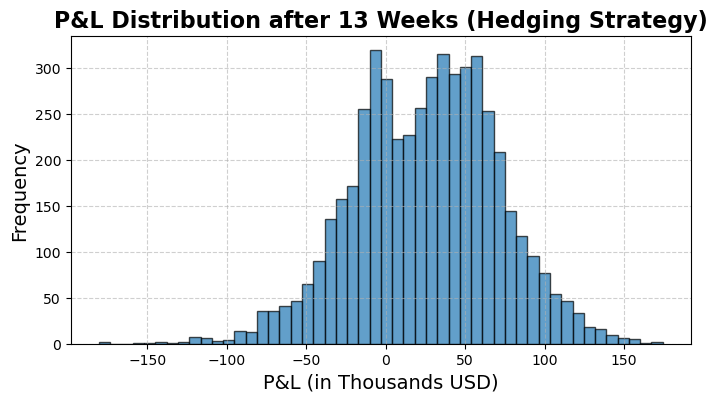

Amount Received by selling Call Option: $ 210136.312


In [37]:
plt.figure(figsize=(8, 4))
plt.hist(final_pl / 1e3, bins=50, edgecolor='black', color='#1f77b4', alpha=0.7)
plt.title("P&L Distribution after 13 Weeks (Hedging Strategy)", fontsize=16, fontweight='bold')
plt.xlabel("P&L (in Thousands USD)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("Amount Received by selling Call Option: $", np.round(sell_amt,3))

#### Question c)

In [39]:
M = 5000
N = 3
S0 = 5600
K = 5600
T = 3/12
sigma = 0.047 * np.sqrt(12)
mu = 0.06
size = 100
n = 10

In [40]:
final_pl, sell_amt = Hedging_strat_sim(M,N,S0,K,T,sigma,mu,size,n)

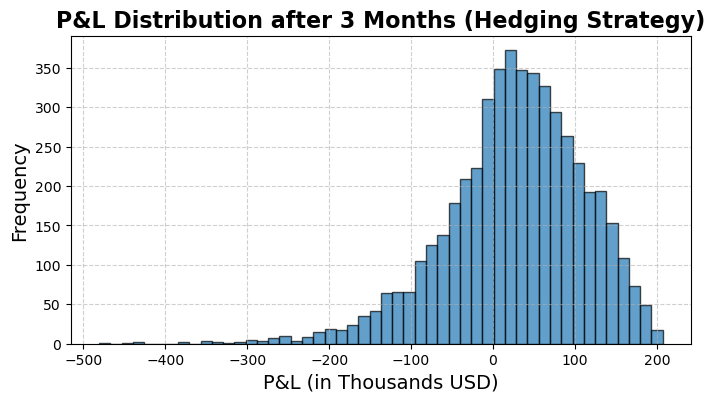

Amount Received by selling Call Option: $ 210136.312


In [41]:
plt.figure(figsize=(8, 4))
plt.hist(final_pl / 1e3, bins=50, edgecolor='black', color='#1f77b4', alpha=0.7)
plt.title("P&L Distribution after 3 Months (Hedging Strategy)", fontsize=16, fontweight='bold')
plt.xlabel("P&L (in Thousands USD)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("Amount Received by selling Call Option: $", np.round(sell_amt,3))

#### Question d)

In [43]:
M = 5000
N = 63
S0 = 5600
K = 5600
T = 63/252
sigma = 0.047 * np.sqrt(12)
mu = 0.06
size = 100
n = 10
final_pl, sell_amt = Hedging_strat_sim(M,N,S0,K,T,sigma,mu,size,n)

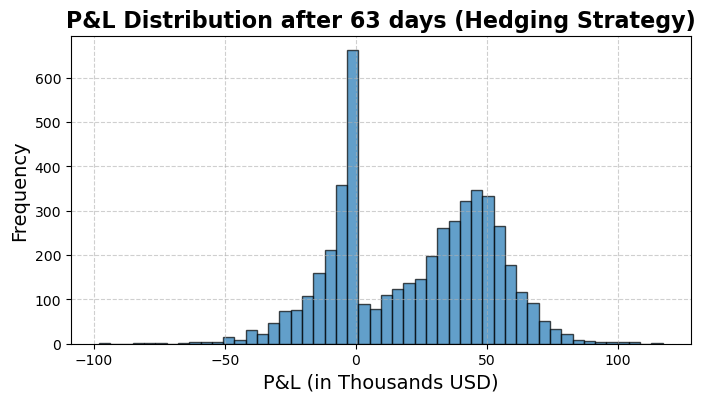

Amount Received by selling Call Option: $ 210136.312


In [44]:
plt.figure(figsize=(8, 4))
plt.hist(final_pl / 1e3, bins=50, edgecolor='black', color='#1f77b4', alpha=0.7)
plt.title("P&L Distribution after 63 days (Hedging Strategy)", fontsize=16, fontweight='bold')
plt.xlabel("P&L (in Thousands USD)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("Amount Received by selling Call Option: $", np.round(sell_amt,3))

### Question e)

In [46]:
M = 5000
N = 63
S0 = 5600
K = 5600
T = 63/252
sigma = 0.047 * np.sqrt(12)
mu = 0.1
size = 100
n = 10
final_pl, sell_amt = Hedging_strat_sim(M,N,S0,K,T,sigma,mu,size,n)

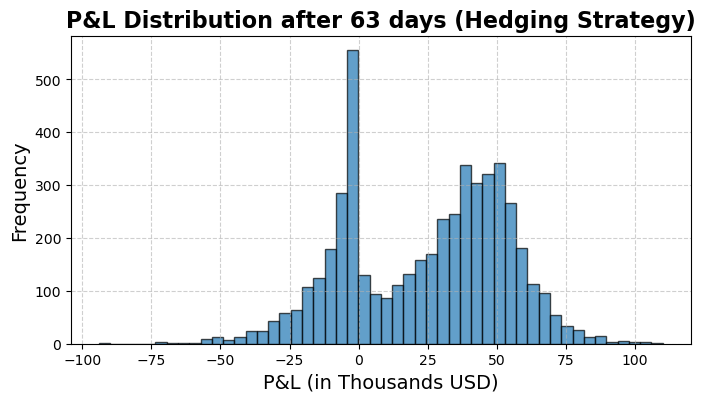

Amount Received by selling Call Option: $ 210136.312


In [47]:
plt.figure(figsize=(8, 4))
plt.hist(final_pl / 1e3, bins=50, edgecolor='black', color='#1f77b4', alpha=0.7)
plt.title("P&L Distribution after 63 days (Hedging Strategy)", fontsize=16, fontweight='bold')
plt.xlabel("P&L (in Thousands USD)", fontsize=14)c
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("Amount Received by selling Call Option: $", np.round(sell_amt,3))

#### Question f)

In [49]:
M = 5000
N = 63
S0 = 5600
K = 5600
T = 63/252
sigma = (0.047 * np.sqrt(12)) + 0.05
mu = 0.1
size = 100
n = 10
final_pl, sell_amt = Hedging_strat_sim(M,N,S0,K,T,sigma,mu,size,n)

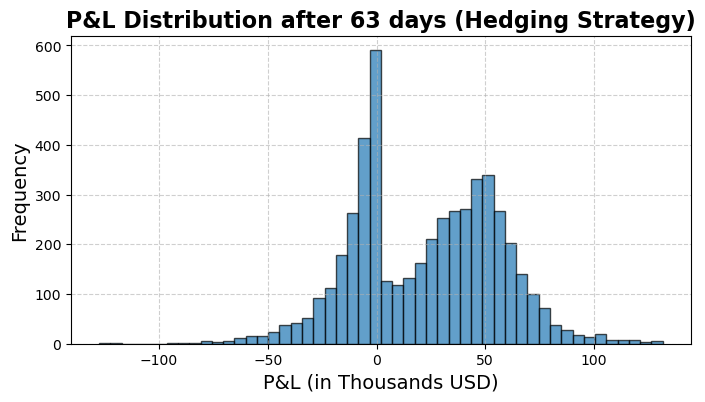

Amount Received by selling Call Option: $ 265328.593


In [50]:
plt.figure(figsize=(8, 4))
plt.hist(final_pl / 1e3, bins=50, edgecolor='black', color='#1f77b4', alpha=0.7)
plt.title("P&L Distribution after 63 days (Hedging Strategy)", fontsize=16, fontweight='bold')
plt.xlabel("P&L (in Thousands USD)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("Amount Received by selling Call Option: $", np.round(sell_amt,3))